In [1]:

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras import Model
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
from sklearn import preprocessing
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
from keras.layers import Dense, LSTM, Dropout, Embedding,Flatten,Bidirectional, MaxPooling1D,GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D,Conv1D
from keras.models import Sequential
from collections import defaultdict
from keras import regularizers
from pprint import pprint
from textwrap import wrap
import json
from keras import optimizers
output_notebook()
%matplotlib inline

/Users/mirco/Documents/comparative-arguments/ve/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Loading BokehJS ...

#### Load and prepare data

In [2]:
vocab_size= 50000
maxlen = 20
output_name_prefix = ''

In [3]:
def load_data(path_file, data_file, remove_no_path=False):
    frame = pd.read_csv(path_file)
    if remove_no_path:
        frame = frame[(frame.path != 'NOPATH')]
    #frame = frame[frame.most_frequent_percentage >= 0.6]
    data_frame = pd.read_csv(data_file)
    data_frame = data_frame[data_frame.sentence.isin(frame.sentence.values.tolist())]
    print('Paths: {} | Data: {}'.format(len(frame),len(data_frame)))
    return frame, data_frame


In [4]:
def load_multi_data(path_files, data_files):
    paths = []
    data = []
    for p,d in zip(path_files,data_files):
        print(p,d)
        pf, df = load_data(p,d)
        paths.append(pf)
        data.append(df)
    return pd.concat(paths), pd.concat(data)
        

In [5]:
def preprocess(path_frame,reshaped=False):
    # transform labels into 3d tensors for lstm
    paths_list = path_frame['path'].values.tolist()
    tokenizer = Tokenizer(num_words=vocab_size,filters='', split=' ')
    tokenizer.fit_on_texts(paths_list)
    input_train = tokenizer.texts_to_sequences(paths_list)
    input_train = sequence.pad_sequences(input_train, maxlen=maxlen)

    # create target labels, one for each path
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(paths_list)
    y_train =  to_categorical(label_encoder.transform(paths_list))
    if reshaped:
        input_train =  input_train.reshape((len(paths_list),maxlen,1))
    pprint('Tokens {}'.format(len(tokenizer.word_counts)))
    print('{} paths total'.format(len(paths_list)))
    print('{} different (target) paths'.format(y_train[0].shape[0]))
    return input_train, y_train


#### Train the network

In [6]:
def plot_lines(history, first,second):
    plt.plot(history.history[first[0]],color=first[1])
    plt.plot(history.history[second[0]],linestyle='--',color=second[1])
    plt.title('{} vs {}'.format(first[0],second[0]))
    plt.xlabel('epoch')
    plt.legend([first[0],second[0]])
    plt.figure(figsize=(5,5))
    plt.show()
    

In [7]:
def train_model(layers,X,y,name='',epochs=100,batch_size=64, shuffle=True, validation_split=0.4, optimizer='rmsprop',
               activation_last_layer='softmax'):
    model = Sequential(name=name)
    [model.add(layer) for layer in layers]
    model.add(Dense(y[0].shape[0],activation=activation_last_layer))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    model.summary()
    history = model.fit(X, y,
    epochs=epochs, batch_size=batch_size,shuffle=shuffle, validation_split=validation_split)
    return history, model
    

#### Prepare the embeddings

In [8]:
def get_embeddings(model,X):
    layer = list(filter(lambda x: x.name == 'embedding',model.layers))[0]

    #assert layer.name == 'embedding'
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=layer.output)
    print(intermediate_layer_model.predict(X).shape)
    return intermediate_layer_model.predict(X)

### Average Embedding

In [9]:
def average_embeddings(embeddings,path_frame,data_frame):
    print(len(path_frame) , len(embeddings))
    assert len(path_frame) == len(embeddings)
    embedding_dict = defaultdict(list)
    mean_embedding_dict = {}
    idx = 0
    for i, row in path_frame.iterrows():
        embedding_dict[row['sentence']].append(embeddings[idx])
        idx += 1
    print(len(embedding_dict), len(data_frame))
    assert len(embedding_dict)== len(data_frame)

    for k,v in embedding_dict.items():
        adder = np.zeros(v[0].shape)
        for val in v:
            adder += val
        adder /= len(v)
        mean_embedding_dict[k] = adder

    #assert len(mean_embedding_dict)== len(data_frame)
    return mean_embedding_dict

In [10]:
def reformat(mean_embedding_dict,path_frame,data_frame):
    X = []
    y = []
    plot_data = []
    plot_x = []
    idx = 0
    embedding_df = pd.DataFrame(columns=['id', 'sentence', 'label', 'embedding', 'paths'])
    for k,v in mean_embedding_dict.items():
        f_slice = path_frame[path_frame.sentence == k]
        label = f_slice.most_frequent_label.values.tolist()[0]
        f_paths = f_slice.path.values.tolist()
        embedding_df.loc[idx] = [f_slice.id.values.tolist()[0], wrap(f_slice.sentence.values.tolist()[0]),label,
                                 v.reshape(-1,1).squeeze().tolist(), [wrap(p) for p in f_paths]]
        idx+=1
        # prepare results for classification
        X.append(v.reshape(-1,1).squeeze().tolist())
        y.append(label)

        # prepare results for t-sne plot
        plot_x.append(v)
        plot_data.append( (label,k,'\n'.join(f_paths)) )
    return X, y, plot_data, plot_x, embedding_df

In [11]:
def save_embedding_df(embedding_df,name):
    embedding_df.to_csv(name+".csv")

### Plot

In [12]:
def tsne_plot(plot_x, plot_data):
    X_embedded = TSNE(n_components=2,verbose=1).fit_transform(plot_x)
    plot_frame = pd.DataFrame(columns=['x','y','class','sentence', 'path'])
    for i,x in enumerate(X_embedded):
        plot_frame.loc[i] = [x[0],x[1],plot_data[i][0],plot_data[i][1],plot_data[i][2]]

    def build_source(label, df):
        df = df[df['class'] == label]
        return ColumnDataSource(data=dict(
        x=df.x.values.tolist(),
        y=df.y.values.tolist(),
        sentence=df.sentence.tolist(),
        path=df.path.tolist(),
        label=df['class'].tolist()))

    colormap = {'WORSE': 'red', 'BETTER': 'green', 'NONE': 'blue'}
    colors = [colormap[x] for x in plot_frame['class']]

    # GROUP tooltips
    hover = HoverTool(tooltips=[
        ("Sentence", "@sentence"),
        ("Path", "@path"),
        ("label", "@label"),
    ])

    p = figure(plot_width=900,  plot_height=900, tools="pan,wheel_zoom,box_zoom,reset,previewsave")
    p.add_tools(hover)

    p.cross(x='x', y='y', source=build_source('NONE', plot_frame),size=5,color='gray')
    p.circle(x='x', y='y', source=build_source('WORSE', plot_frame) ,size=5,color='red')
    p.circle(x='x', y='y', source=build_source('BETTER', plot_frame),size=5,color='green')
    return p

### Classification Test

In [13]:
def classification_test(X,y,data_frame,with_embeddings=False):
    _X = X
    if with_embeddings:
        print("With embeddings")
        lst_lst = np.array([json.loads(l) for l in data_frame.embedding_middle_part.values.tolist()])
        paths_ = np.asarray(X)
        infersent_ = np.array(lst_lst)
        _X = np.concatenate([paths_, infersent_],axis=1)
        assert np.asarray(X).shape[0] == paths_.shape[0] == infersent_.shape[0]
        assert _X.shape[1] == paths_.shape[1] + infersent_.shape[1]
        
    else:
        print("Without embeddings")
    
    kf = StratifiedKFold(n_splits=2, random_state=42)
    
    d = defaultdict(int)

    for train_index, test_index in kf.split(_X,y):
        X_train, X_test = np.array(_X)[train_index], np.array(_X)[test_index]
        y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
     
        log = LogisticRegression()
        log.fit(X_train, y_train)
        pred = log.predict(X_test)
        print(classification_report(y_test,pred,labels=['BETTER', 'WORSE', 'NONE']))
        print('=========\n')
        print("\n\n")

In [14]:
def full_run(layers,path_file,
             name='',reshape=False,epochs=100,batch_size=64, shuffle=True, validation_split=0.2, optimizer='rmsprop'
             ,activation_last_layer='softmax'):
    start = time.mktime(time.localtime())
    path_frame, data_frame = load_multi_data(['../code/data/pre_path_middle_paths_unrestricted_16.csv',
                                        '../code/data/do-not-touch/heldout_pre_path_middle_paths_unrestricted_16.csv'
                                       ],  ['../code/data/data.csv',
                                           '../code/data/do-not-touch/held-out-data.csv'])
    
    
    X, y = preprocess(path_frame,reshaped=reshape)
    history, trained_model = train_model(layers,X,y, name=name,epochs=epochs,batch_size=batch_size,
                                         shuffle=shuffle,activation_last_layer=activation_last_layer, validation_split=validation_split, optimizer=optimizer)

    plot_lines(history,('acc','green'),('val_acc', 'yellowgreen'))
    plot_lines(history,('loss', 'red'), ('val_loss', 'orangered'))
    embeddings = get_embeddings(trained_model,X)
    mean_embedding_dict = average_embeddings(embeddings,path_frame,data_frame)
    _X, _y, plot_data, plot_x, embedding_df = reformat(mean_embedding_dict,path_frame,data_frame)
    classification_test(_X,_y,data_frame)
    #classification_test(_X,_y,data_frame,with_embeddings=True)
    save_embedding_df(embedding_df,name)
    show(tsne_plot(plot_x, plot_data))
    
    duration = (time.mktime(time.localtime()) - start) / 60
    print('Took {} minutes'.format(duration))
    return trained_model

=========== middle_paths_unrestricted_16
../code/data/pre_path_middle_paths_unrestricted_16.csv ../code/data/data.csv
Paths: 10067 | Data: 5759
../code/data/do-not-touch/heldout_pre_path_middle_paths_unrestricted_16.csv ../code/data/do-not-touch/held-out-data.csv
Paths: 2569 | Data: 1455
'Tokens 4091'
12636 paths total
4795 different (target) paths
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 100)           5000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 200)           240800    
_________________________________________________________________
embedding (GlobalMaxPooling1 (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4795)              963795    
Total params: 6,204,595
Trainable params: 6,204,595
Non

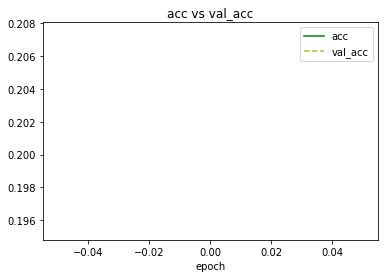

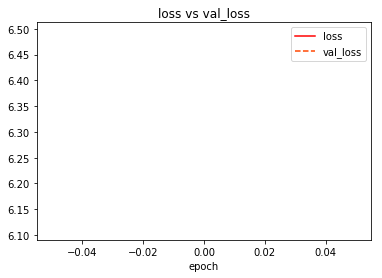

(12636, 200)
12636 12636
6412 7214


AssertionError: 

In [15]:
#full_orig = ['full_paths_original_4', 'full_paths_original_8', 'full_paths_original_16']
#full_unres = ['full_paths_unrestricted_4', 'full_paths_unrestricted_8','full_paths_unrestricted_16']
#middle_orig = ['middle_paths_original_4', 'middle_paths_original_8', 'middle_paths_original_16']
#middle_unres = ['middle_paths_unrestricted_4', 'middle_paths_unrestricted_8', 'middle_paths_unrestricted_16']
#'full_paths_original_4',
for x in ['middle_paths_unrestricted_16']:

    pf = '../code/data/pre_path_{}.csv'.format(x)
    name = x
    print('=========== {}'.format(name))
    lstm = 200
    t_model = full_run([
            Embedding(vocab_size,100,input_length=maxlen, input_shape=(maxlen, )),
            LSTM(lstm,return_sequences=True),
            GlobalMaxPooling1D(name='embedding'),
    ], pf,
        epochs=1,optimizer='rmsprop',batch_size=128,name='combined_16')


In [ ]:
path_frame, data_frame = load_data('../code/data/do-not-touch/heldout_pre_path_middle_paths_unrestricted_16.csv',
                                   '../code/data/do-not-touch/held-out-data.csv', remove_no_path=False)
    
    
Xp, yp = preprocess(path_frame,reshaped=False)

p = t_model.predict_classes(Xp)
from pprint import pprint
pprint(yp[0])